In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader
from Model import FlyingChairsOfficial

# root = r"C:\Users\simon\Desktop\RV\Racunalniski Vid\RV-N3\datasets\FlyingChairs_release"
root = r"E:\datasets\FlyingChairs_release"

# transform = transforms.ToTensor()
# transform = None
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # or (384, 384) if you want to keep aspect ratio closer
    transforms.ToTensor()
])

dataset = FlyingChairsOfficial(root=root, transform=transform, split="train")
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

imgs, flows = next(iter(loader))
print(imgs.shape, flows.shape)


torch.Size([16, 6, 256, 256]) torch.Size([16, 2, 256, 256])


In [2]:
imgs, flows = next(iter(loader))

ValueError: not enough values to unpack (expected 3, got 2)

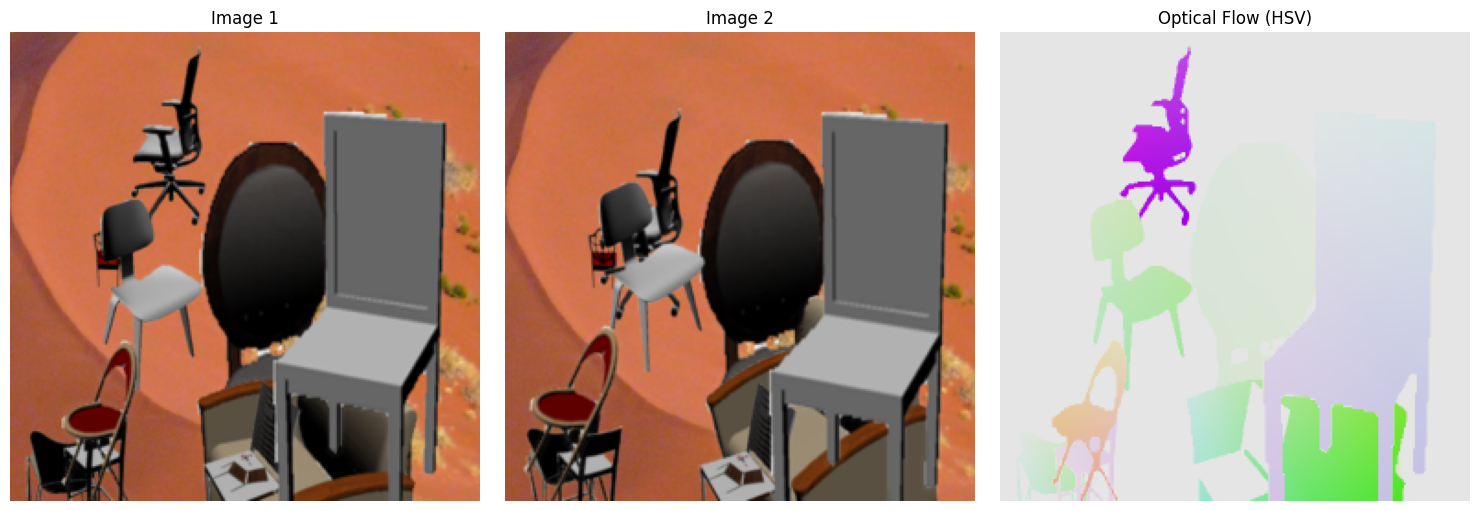

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Extract first sample from batch
img_pair = imgs[0]  # Shape: (6, H, W)
flow = flows[0]     # Shape: (2, H, W)

# Split the 6-channel image into two 3-channel images
img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)

# Convert flow to numpy (H, W, 2)
flow_np = flow.permute(1, 2, 0).cpu().numpy()

# Split flow components
u = flow_np[:, :, 0]
v = flow_np[:, :, 1]

# Magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)  # [-pi, pi]

# Normalize for HSV
h = (ang + np.pi) / (2 * np.pi)  # hue ∈ [0,1]
s = np.clip(mag / (mag.max() + 1e-6), 0, 1)  # saturation ∈ [0,1]
v_ = np.ones_like(s) * 0.9  # brightness

# Build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)

# Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image 1")
plt.imshow(img1)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image 2")
plt.imshow(img2)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Optical Flow (HSV)")
plt.imshow(rgb_flow)
plt.axis("off")

plt.tight_layout()
plt.show()

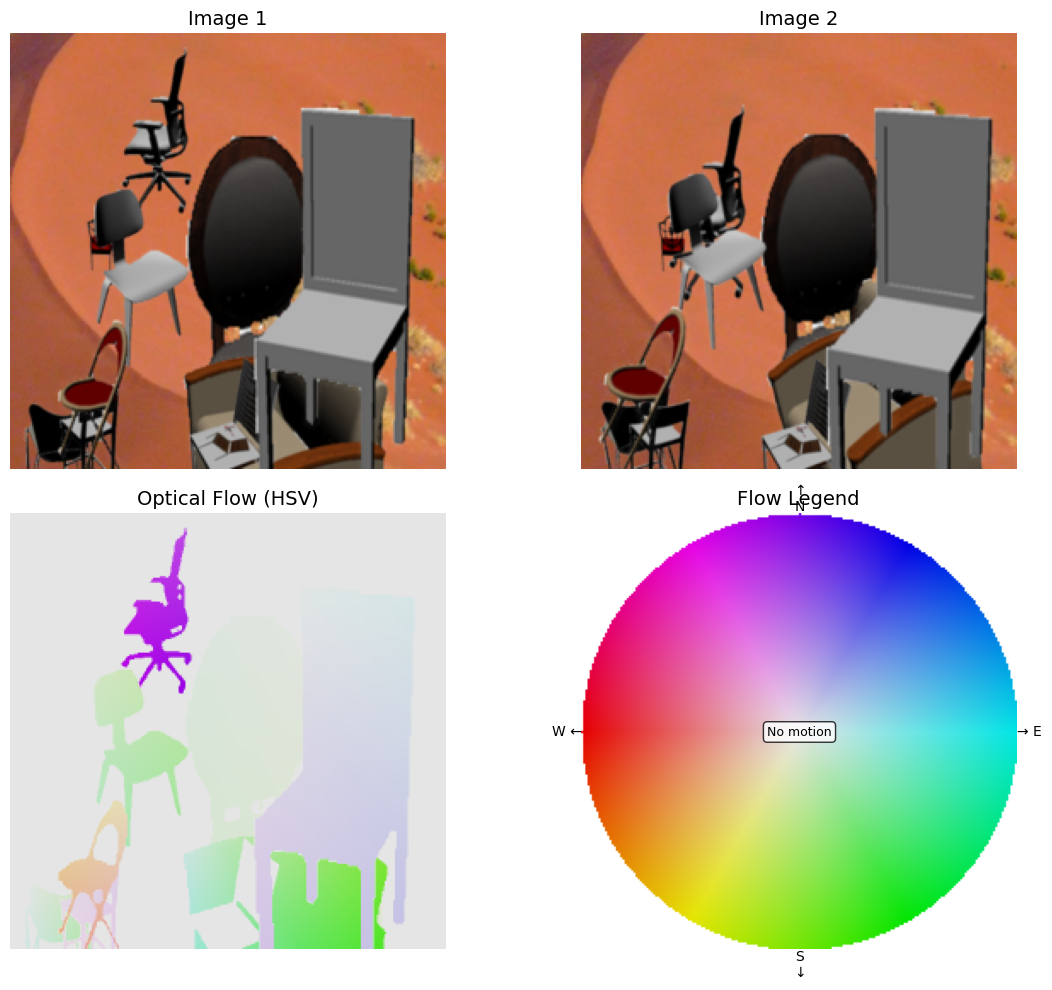

Flow magnitude range: [0.00, 49.89] pixels
Mean flow magnitude: 4.00 pixels


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Extract first sample from batch
img_pair = imgs[0]
flow = flows[0]

# Split images and convert to numpy
img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()
img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()
flow_np = flow.permute(1, 2, 0).cpu().numpy()

# Split flow components
u = flow_np[:, :, 0]
v = flow_np[:, :, 1]

# Magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)

# Normalize for HSV
h = (ang + np.pi) / (2 * np.pi)
s = np.clip(mag / (mag.max() + 1e-6), 0, 1)
v_ = np.ones_like(s) * 0.9

# Build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)

# --- Create colorwheel legend ---
def make_colorwheel(size=256):
    """Create a colorwheel showing flow direction and magnitude"""
    y, x = np.mgrid[-size//2:size//2, -size//2:size//2]

    angle = np.arctan2(-y, x)
    radius = np.sqrt(x**2 + y**2)

    hue = (angle + np.pi) / (2 * np.pi)
    saturation = np.clip(radius / (size // 2), 0, 1)
    value = np.ones_like(saturation) * 0.9

    hsv_wheel = np.stack([hue, saturation, value], axis=-1)
    rgb_wheel = mcolors.hsv_to_rgb(hsv_wheel)

    mask = radius > (size // 2)
    rgb_wheel[mask] = 1

    return rgb_wheel

colorwheel = make_colorwheel(200)

# --- Plot in 2 rows ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First row: images
axes[0, 0].set_title("Image 1", fontsize=14)
axes[0, 0].imshow(img1)
axes[0, 0].axis("off")

axes[0, 1].set_title("Image 2", fontsize=14)
axes[0, 1].imshow(img2)
axes[0, 1].axis("off")

# Second row: flow and legend
axes[1, 0].set_title("Optical Flow (HSV)", fontsize=14)
axes[1, 0].imshow(rgb_flow)
axes[1, 0].axis("off")

axes[1, 1].set_title("Flow Legend", fontsize=14)
axes[1, 1].imshow(colorwheel)
axes[1, 1].axis("off")

# Add text annotations to legend
axes[1, 1].text(200, 100, "→ E", ha='left', va='center', fontsize=10, color='black')
axes[1, 1].text(0, 100, "W ←", ha='right', va='center', fontsize=10, color='black')
axes[1, 1].text(100, 0, "↑\nN", ha='center', va='bottom', fontsize=10, color='black')
axes[1, 1].text(100, 200, "S\n↓", ha='center', va='top', fontsize=10, color='black')
axes[1, 1].text(100, 100, "No motion", ha='center', va='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print flow statistics
print(f"Flow magnitude range: [{mag.min():.2f}, {mag.max():.2f}] pixels")
print(f"Mean flow magnitude: {mag.mean():.2f} pixels")